<a href="https://colab.research.google.com/github/Rachit23110261/llm-finetuning-lora-4bit/blob/main/DeepLearning_Homework_1_23110261.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
transforms.Compose([transforms.ToTensor()]))


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.68MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.07MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import numpy as np

In [ ]:
train_images = np.array([np.array(img[0]) for img in train_set])
train_labels = np.array([img[1] for img in train_set])

test_images = np.array([np.array(img[0]) for img in test_set])
test_labels = np.array([img[1] for img in test_set])

train_images = train_images.squeeze()
test_images = test_images.squeeze()

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

train_images=train_images.reshape(60000,784)
test_images=test_images.reshape(10000,784)

train_labels_one_hot = np.zeros((train_labels.shape[0], 10))
train_labels_one_hot[np.arange(train_labels.shape[0]), train_labels] = 1

train_labels= train_labels_one_hot

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    return x * (1 - x)
def relu(x):
    return np.maximum(0, x)
def relu_derivative(x):
    return (x > 0).astype(float)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_parameters(input_size, hidden_size, output_size, initialization="random"):
    np.random.seed(42)  # To make same random weights for same training
    weights = {}

    if initialization == "xavier":
        weights["W1"] = np.random.randn(input_size, hidden_size) * np.sqrt(1.0 / input_size)
        weights["b1"] = np.zeros((1, hidden_size))
        weights["W2"] = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
        weights["b2"] = np.zeros((1, output_size))

    elif initialization == "he":  # He Initialization for ReLU
        weights["W1"] = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        weights["b1"] = np.zeros((1, hidden_size))
        weights["W2"] = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        weights["b2"] = np.zeros((1, output_size))

    else:
        weights["W1"] = np.random.randn(input_size, hidden_size) * 0.01
        weights["b1"] = np.zeros((1, hidden_size))
        weights["W2"] = np.random.randn(hidden_size, output_size) * 0.01
        weights["b2"] = np.zeros((1, output_size))

    return weights

def forward_propagation(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = softmax(Z2)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def compute_loss_cross_entropy(y_true, y_pred, weights, l1_lambda=0.0, l2_lambda=0.0):
    m = y_true.shape[0]
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    l1_loss = (l1_lambda / m) * (np.sum(np.abs(weights["W1"])) + np.sum(np.abs(weights["W2"])))
    l2_loss = (l2_lambda / (2 * m)) * (np.sum(weights["W1"]**2) + np.sum(weights["W2"]**2))
    total_loss = loss + l1_loss + l2_loss
    return total_loss

def compute_loss_mean_square(y_true, y_pred, l1_lambda=0.0, l2_lambda=0.0):
    m = y_true.shape[0]
    loss = np.sum((y_true - y_pred) ** 2) / m
    l1_loss = (l1_lambda / m) * (np.sum(np.abs(weights["W1"])) + np.sum(np.abs(weights["W2"])))
    l2_loss = (l2_lambda / (2 * m)) * (np.sum(weights["W1"]**2) + np.sum(weights["W2"]**2))
    return loss

input_size= train_images.shape[1]
hidden_size = 128
output_size = 10
weights = initialize_parameters(input_size, hidden_size, output_size)
print(len(weights))
A2, cache = forward_propagation(train_images, weights)
loss = compute_loss_cross_entropy(train_labels, A2, weights)
print(loss)

4
2.3025059537082977


In [ ]:
def backward_propagation(X, y_true, weights, cache, learning_rate=0.01, l1_lambda=0.0, l2_lambda=0.0):
    m = X.shape[0]
    gradients={}
    dZ2 = cache["A2"] - y_true  # Softmax + Cross Entropy Loss derivative
    dW2 = (np.dot(cache["A1"].T, dZ2) / m) + (l1_lambda * np.sign(weights["W2"]) / m) + (l2_lambda * weights["W2"] / m)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = (np.dot(X.T, dZ1) / m) + (l1_lambda * np.sign(weights["W1"]) / m) + (l2_lambda * weights["W1"] / m)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    gradients["W1"] = dW1
    gradients["b1"] = db1
    gradients["W2"] = dW2
    gradients["b2"] = db2

    return gradients


In [ ]:
def gradient_descent(X, y, hidden_size, learning_rate=0.01, epochs=100, batch_size=1, alpha=0.9, init_form='random', l1_lambda=0.0, l2_lambda=0.0):
    input_size = X.shape[1]
    output_size = 10
    weights = initialize_parameters(input_size, hidden_size, output_size, init_form)

    momentum = {key: np.zeros_like(weights[key]) for key in weights}  # Initialize momentum

    m = X.shape[0]

    for epoch in range(epochs):

        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            A2, cache = forward_propagation(X_batch, weights)
            gradients = backward_propagation(X_batch, y_batch, weights, cache, learning_rate, l1_lambda, l2_lambda)

            # Apply Momentum Update Correctly
            for key in ["W1", "b1", "W2", "b2"]:
                momentum[key] = alpha * momentum[key] - learning_rate * gradients[key]  # Update momentum
                weights[key] += momentum[key]  # Apply update

        A2, _ = forward_propagation(X, weights)
        loss = compute_loss_cross_entropy(y, A2, weights)

        if epoch:
            print(f"Epoch {epoch}, Loss: {loss}")

    return weights


In [ ]:
from itertools import product
from sklearn.model_selection import train_test_split
import heapq
def predict(X, weights):
    A2, _ = forward_propagation(X, weights)
    return np.argmax(A2, axis=1)
def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


def grid_search(X, y, test_X, test_y):

    param_grid = list(product(
        [10],
        [0.5],
        [64],
        [1e-4],
        [64, 128],
        ["sgd", "momentum"],
        ["random", "xavier"]
    ))

    best_models = []

    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=42)

    for params in param_grid:
        epochs, l2_lambda, batch_size, learning_rate, hidden_size, optimizer, weight_init = params
        print(f"\nTraining with params: {params}")

        weights = gradient_descent(train_X, train_y, hidden_size=hidden_size, learning_rate=learning_rate,
                                   epochs=epochs, batch_size=batch_size if optimizer== "momentum" else 1, alpha=0.9 if optimizer == "momentum" else 0.0,
                                   init_form=weight_init, l1_lambda=0.0, l2_lambda=l2_lambda)

        val_pred = predict(val_X, weights)
        val_acc = compute_accuracy(np.argmax(val_y, axis=1), val_pred)
        print(f"Validation Accuracy: {val_acc:.2f}%")

        if len(best_models) < 3:
            heapq.heappush(best_models, (val_acc, params, weights))
        else:
            heapq.heappushpop(best_models, (val_acc, params, weights))  # Keep top 3

    best_models.sort(reverse=True, key=lambda x: x[0])

    print("\nTop 3 Hyperparameter Combinations:")
    for rank, (acc, params, _) in enumerate(best_models, 1):
        print(f"{rank}. Accuracy: {acc:.2f}% | Params: {params}")

    best_acc, best_params, best_weights = best_models[0]
    test_pred = predict(test_X, best_weights)
    test_acc = compute_accuracy(test_y, test_pred)

    print(f"\nBest Model Test Accuracy: {test_acc:.2f}%")

    return best_models
top_models = grid_search(train_images, train_labels_one_hot, test_images, test_labels)



Training with params: (10, 0.5, 64, 0.0001, 64, 'sgd', 'random')
Epoch 1, Loss: 1.8965093619865747
Epoch 2, Loss: 1.8493984406766617
Epoch 3, Loss: 1.823434510716316
Epoch 4, Loss: 1.8028555989068993
Epoch 5, Loss: 1.7933723369974415
Epoch 6, Loss: 1.7838828474607096
Epoch 7, Loss: 1.7755649109757696
Epoch 8, Loss: 1.7708273999856605
Epoch 9, Loss: 1.7661571092870272
Validation Accuracy: 47.38%

Training with params: (10, 0.5, 64, 0.0001, 64, 'sgd', 'xavier')
Epoch 1, Loss: 1.8098553519041032
Epoch 2, Loss: 1.8027554552103124
Epoch 3, Loss: 1.7936950742652984
Epoch 4, Loss: 1.7828603405222618
Epoch 5, Loss: 1.7789935045752967
Epoch 6, Loss: 1.7727798787923155
Epoch 7, Loss: 1.7660778076934387
Epoch 8, Loss: 1.7631662397184613
Epoch 9, Loss: 1.7595909640856136
Validation Accuracy: 47.93%

Training with params: (10, 0.5, 64, 0.0001, 64, 'momentum', 'random')
Epoch 1, Loss: 2.2365555419422045
Epoch 2, Loss: 2.1046099019276876
Epoch 3, Loss: 1.8724679587292743
Epoch 4, Loss: 1.63042252148

In [ ]:
c=0
best_y_pred=np.zeros(test_labels.shape)
best_accuracy=0
for i in top_models:
  best_acc, best_params, best_weights = i
  test_pred = predict(test_images, best_weights)
  test_acc = compute_accuracy(test_labels, test_pred)
  if test_acc>best_accuracy:
    best_accuracy=test_acc
    best_y_pred=test_pred
  c+=1
  print(f"\nFinal Test Accuracy with Model {c} :{test_acc:.2f}%")



Final Test Accuracy with Model 1 :75.24%

Final Test Accuracy with Model 2 :74.27%

Final Test Accuracy with Model 3 :64.65%


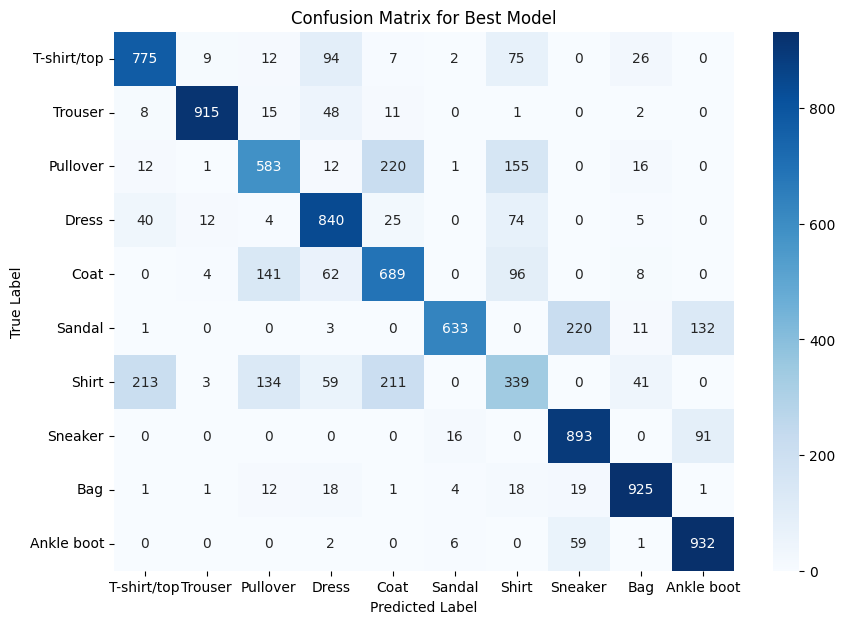

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, best_y_pred)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


### Question 2
We are given the function:  

$f(x) = 1 + \tanh\left(\frac{wx + b}{2}\right)$  

The loss function is:  

$L(x, y) = \frac{1}{2} (y - f(x))^2$  

We need to compute $ \frac{\partial L}{\partial w} $ and $ \frac{\partial L}{\partial b} $.  

### Step 1: Compute $ \frac{\partial L}{\partial f} $  

$\frac{\partial L}{\partial f} = - (y - f(x))$  

### Step 2: Compute $ \frac{\partial f}{\partial z} $, where $ z = \frac{wx + b}{2} $  

Since $ f(x) = 1 + \tanh(z) $, we differentiate:  

$\frac{\partial f}{\partial z} = \text{sech}^2(z)$  

Since:  

$\text{sech}^2(z) = 1 - \tanh^2(z)$  

we get:  

$\frac{\partial f}{\partial z} = 1 - \tanh^2(z)$  

### Step 3: Compute $ \frac{\partial z}{\partial w} $ and $ \frac{\partial z}{\partial b} $  

$z = \frac{wx + b}{2}$  

$\frac{\partial z}{\partial w} = \frac{x}{2}, \quad \frac{\partial z}{\partial b} = \frac{1}{2}$  

### Step 4: Compute $ \frac{\partial L}{\partial w} $  

Using the chain rule:  

$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial z} \cdot \frac{\partial z}{\partial w}$  

Substituting values:  

$\frac{\partial L}{\partial w} = - (y - f(x)) \cdot (1 - \tanh^2(z)) \cdot \frac{x}{2}$  

$\frac{\partial L}{\partial w} = - (y - f(x)) \cdot \left(1 - \tanh^2\left(\frac{wx + b}{2}\right)\right) \cdot \frac{x}{2}$  

### Step 5: Compute $ \frac{\partial L}{\partial b} $  

$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial z} \cdot \frac{\partial z}{\partial b}$  

Substituting values:  

$\frac{\partial L}{\partial b} = - (y - f(x)) \cdot (1 - \tanh^2(z)) \cdot \frac{1}{2}$  

$\frac{\partial L}{\partial b} = - (y - f(x)) \cdot \left(1 - \tanh^2\left(\frac{wx + b}{2}\right)\right) \cdot \frac{1}{2}$  

### Final Answer:  

$\frac{\partial L}{\partial w} = - (y - f(x)) \cdot \left(1 - \tanh^2\left(\frac{wx + b}{2}\right)\right) \cdot \frac{x}{2}$  

$\frac{\partial L}{\partial b} = - (y - f(x)) \cdot \left(1 - \tanh^2\left(\frac{wx + b}{2}\right)\right) \cdot \frac{1}{2}$  


## Question 3
Receptive field of a layer in convulational network is the number of nodes by which its value is affected in layer 0 of the network:

for layer 0 the receptive field is 1 as no convolutional layer is applied.

for each node in layer 1 its value is affected by k nodes in layer 0 where k is the kernel size.

So, its receptive field value is k which is 7.

for each node in layer 2 its value is affected by k nodes in layer 1 and each of the k nodes is affected by k nodes of layer 0. But from every k of them k-1 overlap, So the total must be k+ k-1 nodes in layer 0 which affect a single node in layer 2.

So, its receptive field value is 2k-1 which is 13.

Similiarily for layer 3, k nodes from layer 2 affect one node of layer 3, So, 2k-1 nodes would affect from layer 1 and  (k+ (2k-1) - 1) nodes would affect from layer 0.

So, receptive field of third layer is 3k-2 =19 for k==7


The general formula for a 1D dilated convolution is:  

$$
y(i) = \sum_{j=0}^{k-1} x(i + j \cdot d) \cdot w(j)
$$  
where:  
- $ x(i) $ is the input signal,  
- $ w(j) $ is the filter/kernel,  
- $ j $ iterates over the kernel size,  
- $ d $ is the dilation rate, which increases the spacing between sampled values,  
- $ s $ is the stride, determining how the filter moves across the input.  

### **Step 2: Expanding the Formula for Given Values**  
Since we have **$ k = 7 $**, **$ d = 3 $**, and **$ s = 3 $**, the convolution at position $ i $ becomes:  

$$
y(i) = x(i) \cdot w(0) + x(i + 3) \cdot w(1) + x(i + 6) \cdot w(2) + x(i + 9) \cdot w(3) + x(i + 12) \cdot w(4) + x(i + 15) \cdot w(5) + x(i + 18) \cdot w(6)
$$  

where each $ x $ term is spaced by **$ d = 3 $**. The convolution moves with a **stride of $ 3 $**, meaning that the next position would be **$ i + 3 $**.




